In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the PINN model
class PINN(nn.Module):
    def __init__(self, num_hidden_layers=3, neurons_per_layer=30):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = torch.tanh

        # Create hidden layers dynamically
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))

        self.input_layer = nn.Linear(1, neurons_per_layer)
        self.output_layer = nn.Linear(neurons_per_layer, 1)

        # Trainable parameters
        self.k = nn.Parameter(torch.tensor(3.0, dtype=torch.float32, device=device))
        self.r = nn.Parameter(torch.tensor(1.0, dtype=torch.float32, device=device))

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

# Compute the residual of the ODE
def ode_residual(model, t):
    t.requires_grad_(True)
    P = model(t)
    P_t = torch.autograd.grad(P, t, grad_outputs=torch.ones_like(P), create_graph=True)[0]
    residual = P_t - model.r * P * (1 - P / model.k)
    return residual

# Define the loss function
def pinn_loss(model, t_interior, P_data, t_init, P_init):
    residual_loss = torch.mean(ode_residual(model, t_interior) ** 2)
    P_pred = model(t_interior)
    data_loss = torch.mean((P_pred - P_data) ** 2)
    P_pred_init = model(t_init)
    init_loss = torch.mean((P_pred_init - P_init) ** 2)
    return residual_loss + data_loss + init_loss

# Training step
def train_step(model, t_interior, P_data, t_init, P_init, optimizer):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_interior, P_data, t_init, P_init)
    loss.backward()
    optimizer.step()
    return loss.item()

# Data
P_data = np.array([379, 423, 472, 523, 610, 738, 995, 1231, 1457, 1783, 2239, 2805, 3366, 3852, 4250, 4317, 4691, 5149, 5689, 5737, 6016])
t_data = np.linspace(0, 20, 21)
P_data = P_data / max(P_data)
t_data = t_data / max(t_data)
P0 = P_data[0]

# Convert to tensors and move to GPU
t_data = torch.tensor(t_data, dtype=torch.float32, device=device).view(-1, 1)
P_data = torch.tensor(P_data, dtype=torch.float32, device=device).view(-1, 1)
t_init = t_data[0].view(-1, 1)
P_init = torch.tensor([[P0]], dtype=torch.float32, device=device)

# Initialize model and optimizer
model = PINN(num_hidden_layers=3, neurons_per_layer=30).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10000
for epoch in range(epochs):
    loss = train_step(model, t_data, P_data, t_init, P_init, optimizer)
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss}, Estimated k: {model.k.item()}, Estimated r: {model.r.item()}')

# Final parameter estimation
print(f"Estimated k: {model.k.item()}")
print(f"Estimated r: {model.r.item()}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.5006508231163025, Estimated k: 3.000999927520752, Estimated r: 0.9990000128746033
Epoch 500, Loss: 0.03906407952308655, Estimated k: 3.5101685523986816, Estimated r: 1.47319495677948
Epoch 1000, Loss: 0.020331183448433876, Estimated k: 3.9408581256866455, Estimated r: 1.8810267448425293
Epoch 1500, Loss: 0.011383498087525368, Estimated k: 4.246581554412842, Estimated r: 2.1904406547546387
Epoch 2000, Loss: 0.007809135131537914, Estimated k: 4.431139945983887, Estimated r: 2.4164605140686035
Epoch 2500, Loss: 0.006124875042587519, Estimated k: 4.493834495544434, Estimated r: 2.572045087814331
Epoch 3000, Loss: 0.005604942329227924, Estimated k: 4.452014446258545, Estimated r: 2.6763370037078857
Epoch 3500, Loss: 0.005364900920540094, Estimated k: 4.322193145751953, Estimated r: 2.745676040649414
Epoch 4000, Loss: 0.005376214161515236, Estimated k: 4.118803977966309, Estimated r: 2.7948813438415527
Epoch 4500, Loss: 0.005043677054345608, Estimated k: 3.860624313354492, E

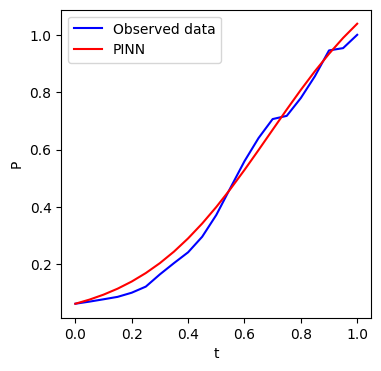

In [ ]:

# Predictions
P_pred = model(t_data).detach().cpu().numpy()
t_data_np = t_data.detach().cpu().numpy()
P_data_np = P_data.detach().cpu().numpy()
P_pred_np = (P0 * model.k.item()) / (P0 + (model.k.item() - P0) * np.exp(-model.r.item() * t_data_np))

# Plot results
plt.figure(figsize=(4, 4))
plt.plot(t_data_np, P_data_np, color='blue', label='Observed data')
plt.plot(t_data_np, P_pred_np, color='red', label='PINN')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.savefig("plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
from numpy import linalg
linalg.norm(P_data_np - P_pred_np)

0.14772174